<a href="https://colab.research.google.com/github/mhabib80/Sample-Projects/blob/master/Goodreads_Webscrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
import re
from datetime import datetime
import dateutil
import pandas as pd
import numpy as np
import requests
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Data Science/Data Sets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Data Science/Data Sets


# Data Extraction/Transformation

In [ ]:
# Read all answers from the google spreadsheet
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Copy of DP Book Recommendations May').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
book_rec = [book.strip() for sublist in rows for book in sublist] 
book_rec = list(set(book_rec)) #remove duplicates
pd.DataFrame(book_rec).to_csv('book_rec.csv') #save a csv copy


In [ ]:
book_rec[:10]

['Orson Scott Card - Enders Game',
 'My Brilliant Friend by Elena Ferrante',
 'The Westing Game by Ellen Raskin',
 'Candide (Voltaire)',
 'AN ELegant Defense: the Extraordinary New Science of the Immune System',
 'Matilda - Roald Dahl',
 'The Tresspasser by Tana French',
 'The Dark Tower Series by Stephen King',
 'Casino Royale',
 'Harry Potter franchise']

In [ ]:
len(book_rec)

505

In [ ]:
#save the book_rec list as a pickle object
with open('book_rec_list.txt', 'wb') as fp:
  pickle.dump(book_rec, fp)

# Scrapping Google

In [ ]:
#open the book_rec list saved as a pickle object
with open('book_rec_list.txt', 'rb') as fp:
  book_rec = pickle.load(fp)

In [ ]:
# google each answer in the book_rec list to find the exact book name and a goodreads link to it

links=[]

for book in book_rec:
  book = '+'.join(book.split()).replace('"', '') + '+book' #add '+' between words in the book title to later append to the google search. Remove the quotes for better search results
  results = requests.get('https://www.google.com/search?', params={'q':book}).text 
  soup = BeautifulSoup(results, 'html.parser')

  try:
    gr_page_ = soup.find('a', href=True, text='Goodreads').get('href') #Find the Goodreads link in the right side pane of the search results (common with popular books)
  except: # for not so popular books, iterate through all the search result links to find the goodreads page
    for search_result in soup.find_all('a', href=True):
      if search_result['href'].startswith('/url?q=https://www.goodreads.com/book'):
        gr_page_ = search_result['href']
        break
      
  if gr_page_:
    gr_page = re.search('https://www.goodreads.com/(\w+/)?book/show/\d+', gr_page_).group()
    links.append(gr_page)
  else:
    continue

In [ ]:
links = list(set(links)) #remove duplicates
len(links)

369

In [ ]:
links[:10]

['https://www.goodreads.com/book/show/19898',
 'https://www.goodreads.com/book/show/6759',
 'https://www.goodreads.com/book/show/3758',
 'https://www.goodreads.com/book/show/36534574',
 'https://www.goodreads.com/book/show/3591262',
 'https://www.goodreads.com/book/show/214579',
 'https://www.goodreads.com/book/show/25698',
 'https://www.goodreads.com/book/show/18293427',
 'https://www.goodreads.com/book/show/6572270',
 'https://www.goodreads.com/book/show/37976541']

In [ ]:
#save the goodread links as a pickle object
with open('links.txt', 'wb') as fp:
  pickle.dump(links, fp)

# Scrapping Goodreads book pages

In [ ]:
with open('links.txt', 'rb') as fp:
  links = pickle.load(fp)

In [ ]:
books_l = [] #create an empty list to append each book's dictionary to.

In [ ]:
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36'}

for link in links:

  # book_page = requests.get(f'http://api.scraperapi.com?api_key={API_Key}&url={link}').text # API_Key = '8798077913fa35b81c8899ac75f19c67'
  book_page = requests.get(link, headers=headers).text
  soup = BeautifulSoup(book_page, 'html.parser')
  book = {}

  #book title
  book['title'] = soup.head.find(property='og:title')['content']
    

  #book author
  try:
    book['author'] = soup.head.find(property='books:author')['content'].split('.')[-1]
  except:
    book['author'] = ', '.join(name.get_text() for name in soup.find(itemprop = 'author').find_all(itemprop='name'))
     

  # book description
  try: #desriptions that are minimized
    book['desc'] = soup.find(id='description').find('span', style='display:none').get_text()
  except:
    try: #descriptions that are fully displayed
      book['desc'] = soup.find(id='description').get_text().strip()
    except:#books with no descriptoin
      book['desc'] = 'NA'
      

  #book ratings
  book['rating_value'] = soup.find(id='bookMeta').find(itemprop="ratingValue").get_text().strip()
  book['rating_count'] = soup.find(itemprop='ratingCount')['content']
  book['review_count'] = soup.find(itemprop='reviewCount')['content']


  #book publication date
  try: #attempt to get the first_published date first
    pub = soup.find('nobr', class_="greyText").get_text().strip()[1:-1].replace('first published ', '')
  except: #if no first_pub date available, then get published date
    try:
      pub_t= soup.find('div', class_='row', text=re.compile(r' Published')).get_text()
      pub = re.search(r'\w{3,} \d+\w{2} \d{4}', pub_t).group()
    except: 
      book['pub_date'] = 'NA' #use ifnull
  if pub:
    book['pub_date'] = dateutil.parser.parse(pub).year


  #book page count
  book['pages'] = soup.find(itemprop="numberOfPages").get_text().split()[0]


  #book genres
  book['genres'] = [genre.get_text() for genre in soup.find_all('a', href=True, class_="actionLinkLite bookPageGenreLink")]

  print(book)
  books_l.append(book)
  links.pop(0)
  time.sleep(np.random.randint(5,20))

In [ ]:
len(books_l)

369

In [ ]:
books_l[0]

{'author': 'John_McPhee',
 'desc': 'At various times in a span of fifteen years, John McPhee made geological field surveys in the company of Eldridge Moores, a tectonicist at the University of California at Davis. The result of these trips is Assembling California, a cross-section in human and geologic time, from Donner Pass in the Sierra Nevada through the golden foothills of the Mother Lode and across the Great Central Valley to the wine country of the Coast Ranges, the rock of San Francisco, and the San Andreas family of faults. The two disparate time scales occasionally intersect--in the gold disruptions of the nineteenth century no less than in the earthquakes of the twentieth--and always with relevance to a newly understood geologic history in which half a dozen large and separate pieces of country are seen to have drifted in from far and near to coalesce as California.McPhee and Moores also journeyed to remote mountains of Arizona and to Cyprus and northern Greece, where rock of

In [ ]:
pd.DataFrame(books_l).to_csv('books_df.csv')

# EDA

In [ ]:
plt.rcParams['text.color'] = 'darkgrey'
plt.rcParams['axes.labelcolor']='darkgrey'
plt.rcParams['axes.edgecolor']='darkgrey'
plt.rcParams['axes.linewidth']=0.5
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rc('axes.spines', left=True, top=False, right=False)
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['axes.titlelocation']= 'left' 
plt.rcParams['axes.titlepad'] = 10

In [ ]:
books_df = pd.DataFrame(books_l)
books_df.head()

,title,author,desc,rating_value,rating_count,review_count,pub_date,pages,genres
0,Assembling California,John_McPhee,"At various times in a span of fifteen years, John McPhee made geological field surveys in the company of Eldridge Moores, a tectonicist at the University of California at Davis. The result of thes...",4.17,1858,147,1992,294,"[Science, Nonfiction, Science, Geology, History, Environment, Nature, Science, Natural History, Science, Geography, Writing, Essays, Travel, Environment]"
1,"Casino Royale (James Bond, #1)",Ian_Fleming,"British Secret Service agent James Bond, a.k.a. 007, is sent to play in a high-stakes baccarat game in an effort to take down Le Chiffre, a financier for the villainous SMERSH. Things get more com...",3.74,77663,4701,1953,192,"[Fiction, Thriller, Classics, Mystery, Spy Thriller, Espionage, Mystery, Crime, Adventure, Novels, Audiobook, Thriller, Mystery Thriller]"
2,"Casino Royale (James Bond, #1)",Ian_Fleming,"British Secret Service agent James Bond, a.k.a. 007, is sent to play in a high-stakes baccarat game in an effort to take down Le Chiffre, a financier for the villainous SMERSH. Things get more com...",3.74,77663,4701,1953,192,"[Fiction, Thriller, Classics, Mystery, Spy Thriller, Espionage, Mystery, Crime, Adventure, Novels, Audiobook, Thriller, Mystery Thriller]"
3,Cutting for Stone,Abraham_Verghese,"A sweeping, emotionally riveting first novel - an enthralling family saga of Africa and America, doctors and patients, exile and home.Marion and Shiva Stone are twin brothers born of a secret unio...",4.29,350284,26135,2009,541,"[Fiction, Historical, Historical Fiction, Cultural, Africa, Book Club, Health, Medicine, Eastern Africa, Ethiopia, Medical, Novels, Literary Fiction, Historical]"
4,An Inquiry into the Nature and Causes of the Wealth of Nations,Adam_Smith,"Adam Smith's masterpiece, first published in 1776, is the foundation of modern economic thought and remains the single most important account of the rise of, and the principles behind, modern capi...",3.85,32846,1086,1776,1076,"[Economics, Nonfiction, Philosophy, Classics, History, Politics, Business, Economics, Finance, Politics, Political Science, Sociology]"


In [ ]:
books_df.shape

(369, 9)

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         369 non-null    object 
 1   author        369 non-null    object 
 2   desc          369 non-null    object 
 3   rating_value  369 non-null    float64
 4   rating_count  369 non-null    int64  
 5   review_count  369 non-null    int64  
 6   pub_date      369 non-null    int64  
 7   pages         369 non-null    int64  
 8   genres        369 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 26.1+ KB


In [ ]:
#Change data types
books_df[['rating_count', 'review_count', 'pub_date', 'pages']] = books_df[['rating_count', 'review_count', 'pub_date', 'pages']].astype(int)
books_df['rating_value'] = books_df['rating_value'].astype(float)

In [ ]:
books_df.describe()

,rating_value,rating_count,review_count,pub_date,pages
count,369.000000,3.690000e+02,369.000000,369.000000,369.000000
mean,4.093333,2.655881e+05,11716.891599,1987.287263,484.826558
std,0.374814,5.528060e+05,18446.373122,49.770712,442.239253
min,0.000000,0.000000e+00,0.000000,1605.000000,6.000000
25%,3.960000,7.012000e+03,654.000000,1974.000000,300.000000
50%,4.130000,7.208000e+04,4701.000000,2004.000000,384.000000
75%,4.280000,2.349000e+05,13323.000000,2017.000000,552.000000
max,4.740000,4.110811e+06,112601.000000,2020.000000,4912.000000


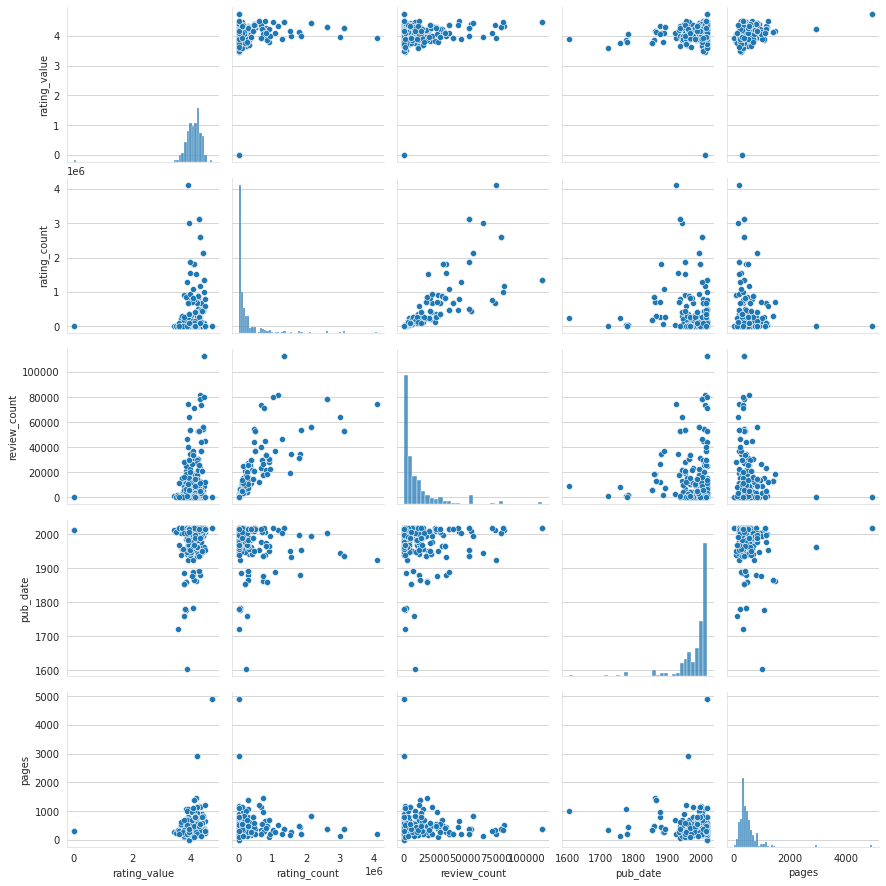

In [ ]:
sns.pairplot(books_df)

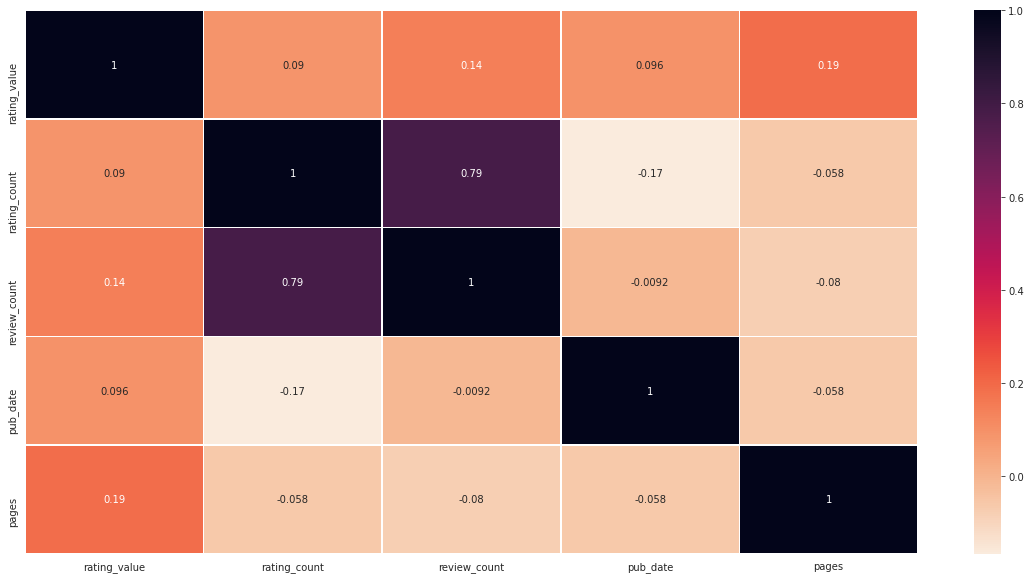

In [ ]:
sns.heatmap(books_df.corr(), annot=True, linewidths=0.5, cmap='rocket_r');

**Explore genres**

In [ ]:
#explore genres
from collections import Counter
most_common_genres = Counter([tag for list in books_df.genres for tag in list]).most_common(30)
genres = pd.DataFrame(most_common_genres, columns=['genre', 'count']).set_index('genre')
genres.head()

,count
genre,
Fiction,210
Historical,199
Audiobook,167
Literature,167
Nonfiction,148


<Figure size 720x576 with 0 Axes>

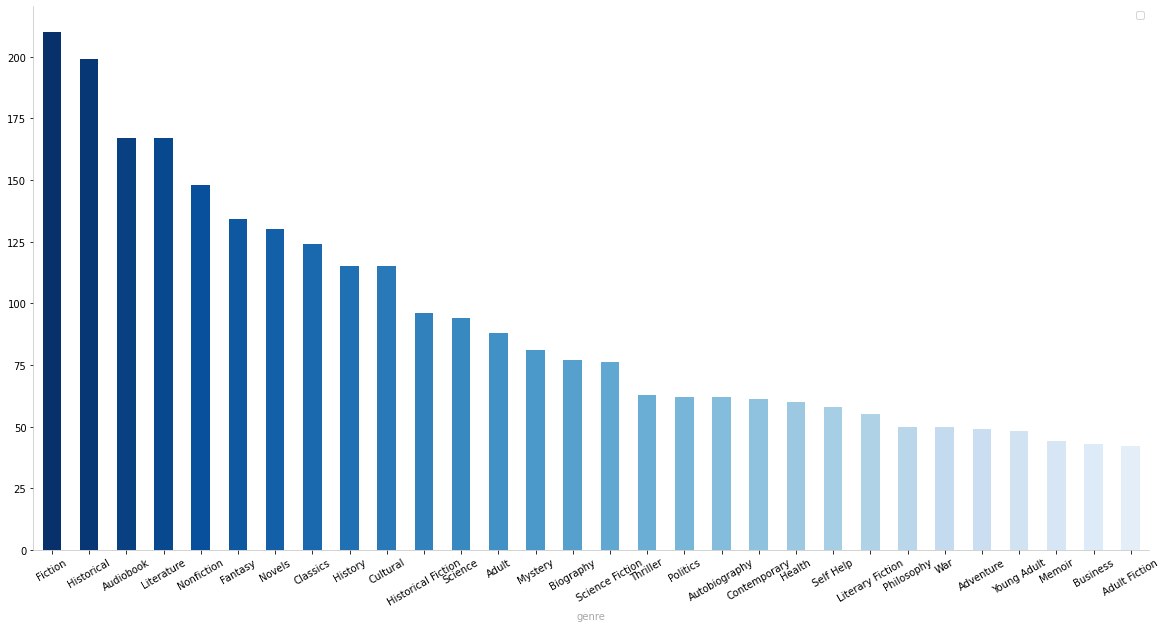

In [ ]:
plt.figure(figsize=(10,8))
ax = genres.plot(kind='bar', color=[cm.Blues_r(np.linspace(0,0.9,30))], rot=30)
ax.legend([]);

**Publication year**

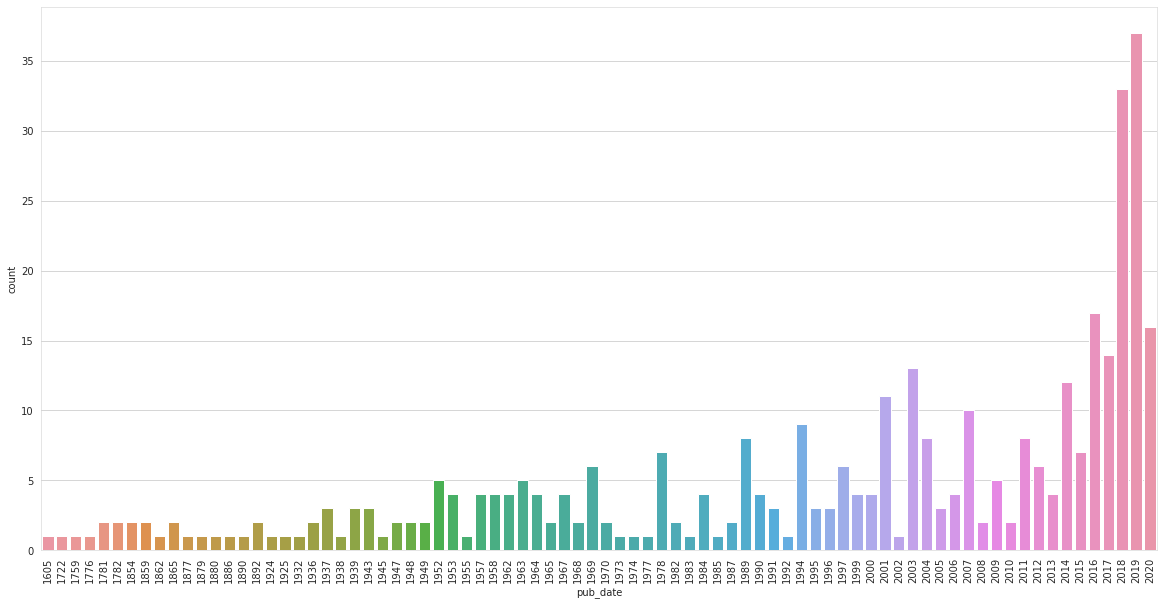

In [ ]:
sns.set_palette('tab10')
sns.countplot(data = books_df, x = 'pub_date' )
plt.xticks(rotation = 90);

**Rating Value & Count**

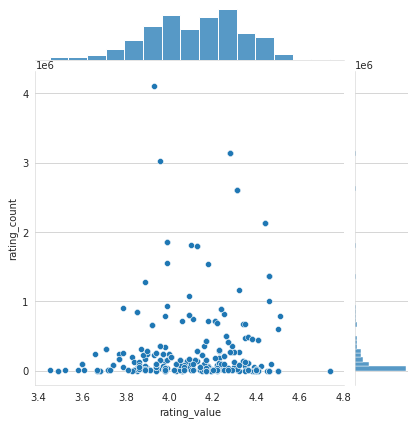

In [ ]:
sns.jointplot(data = books_df[books_df['rating_value']!=0], y ='rating_count', x='rating_value');

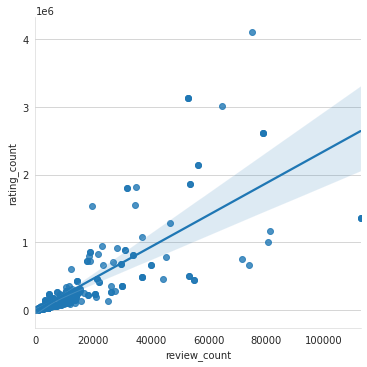

In [ ]:
sns.lmplot(data = books_df[books_df['rating_value']!=0], y ='rating_count', x='review_count');